# README

The ultimate aim of this notebook is to construct a **naive** *implied order book* for SPX options (options on the S&P500). We will explain what this means in more detail. The data comes from the Chicago Board Options Exchange (CBOE). The data is delayed (hence why it's free!). Here's the link to the page where the data comes from. https://www.cboe.com/delayed_quotes/spx/quote_table

When we make a call to the API we get back a table containing all option contracts on the S&P500 (one row per contract), with some info about the contract:
* The ID tells us the expiry, whether it's a put or a call and the strike price.
* The current bid and ask prices, as well as the bid and ask sizes
* Implied Vol (need to work out whether this is from bid, ask, mid or something else - may need to write my own Black-Scholes function for this)
* Open Interest (total number of open contracts)
* Volume
* The Greeks - delta, gamma, vega, theta, rho, theo
* Some metrics about how the price has changed
* Last traded time and last traded price. This can help to show liquidity.

https://perfiliev.com/blog/how-to-calculate-gamma-exposure-and-zero-gamma-level/

# Imports

In [1]:
import requests
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Fetch Data

In [2]:
# Symbol for SPX options
symbol = '_SPX'

# Start session
s = requests.Session()

# Make API call and check status code
response = s.get(f'https://cdn.cboe.com/api/global/delayed_quotes/options/{symbol}.json')
if response.status_code != 200:
    raise Exception(f"Unable to fetch data. Status code is {response.status_code}")

# Get data as json
data = json.loads(response.content)

# Close session
s.close()

In [3]:
# Get timestamp
timestamp = datetime.strptime(data['timestamp'], "%Y-%m-%d %H:%M:%S")

# Get index price
index_price = data['data']['current_price']

# Get options data
df = pd.DataFrame(
    data=data['data']['options']
)

df['Index Price'] = index_price
df['timestamp'] = timestamp

# Extract info from the ID column
without_w = df['option'].str.replace("W", "")
df['Expiry'] = without_w.str[3:9].astype(int)
df['Type'] = without_w.str[9]
df['Strike'] = without_w.str[11:-3].astype(int)

# Calculate moneyness
df['Moneyness'] = (df['Index Price'] - df['Strike']) / df['Strike']

# Order by expiry
df = df.sort_values(by='Expiry')

df

,option,bid,bid_size,ask,ask_size,iv,open_interest,volume,delta,gamma,...,last_trade_price,last_trade_time,percent_change,prev_day_close,Index Price,timestamp,Expiry,Type,Strike,Moneyness
7643,SPXW241122P05770000,0.0,0.0,0.05,579.0,0.5290,2060.0,306.0,-0.0025,0.0001,...,0.05,2024-11-22T10:53:20,-90.0000,0.500000,5963.9902,2024-11-22 17:22:29,241122,P,5770,0.033620
7716,SPXW241122C05955000,13.7,4.0,13.90,12.0,0.1676,2321.0,13306.0,0.6879,0.0178,...,13.96,2024-11-22T12:07:16,-28.0412,19.400000,5963.9902,2024-11-22 17:22:29,241122,C,5955,0.001510
7715,SPXW241122P05950000,3.4,17.0,3.50,133.0,0.1750,4183.0,33132.0,-0.2388,0.0149,...,3.30,2024-11-22T12:07:21,-77.7027,14.800000,5963.9902,2024-11-22 17:22:29,241122,P,5950,0.002351
7714,SPXW241122C05950000,17.5,6.0,17.80,6.0,0.1755,7200.0,16366.0,0.7612,0.0149,...,18.00,2024-11-22T12:07:01,-19.8218,22.450000,5963.9902,2024-11-22 17:22:29,241122,C,5950,0.002351
7713,SPXW241122P05945000,2.6,19.0,2.65,87.0,0.1835,1015.0,16895.0,-0.1844,0.0121,...,2.57,2024-11-22T12:07:24,-80.3817,13.100000,5963.9902,2024-11-22 17:22:29,241122,P,5945,0.003194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7245,SPX291221P03600000,104.7,73.0,115.30,18.0,0.2441,324.0,0.0,-0.0664,0.0000,...,119.72,2024-11-06T12:28:35,0.0000,115.549999,5963.9902,2024-11-22 17:22:29,291221,P,3600,0.656664
7244,SPX291221C03600000,2934.9,5.0,3014.90,5.0,0.2472,1.0,0.0,0.9674,0.0000,...,0.00,None,0.0000,2961.500000,5963.9902,2024-11-22 17:22:29,291221,C,3600,0.656664
7243,SPX291221P03500000,96.4,73.0,106.50,18.0,0.2469,114.0,0.0,-0.0614,0.0000,...,107.00,2024-11-19T16:11:36,0.0000,106.949997,5963.9902,2024-11-22 17:22:29,291221,P,3500,0.703997
7257,SPX291221P04200000,166.7,76.0,180.60,21.0,0.2293,633.0,0.0,-0.1022,0.0001,...,255.00,2024-09-24T15:01:07,0.0000,181.300003,5963.9902,2024-11-22 17:22:29,291221,P,4200,0.419998


# Gamma Exposure (GEX)
We want to know, at each index level, how much gamma are the market makers sitting on, as this will give us a picture of how they must delta hedge. To do this, we need to know how many of each particular option the market makers hold AND whether they're long or short each option. We can know the first thing from open interest but for the second thing the data doesn't tell us whether they're long or short (they keep this secret of course!).

So a naive assumption to start with is that the dealers are long calls and short puts, which on the whole index isn't an entirely terrible assumption. We could use actual trades data to construct a more accurate picture of whether they're long or short (based on where trades are being closed relative to the bid, mid, ask can tell you whether the trade is speculative or a hedge for example.). However, this comes at a big cost and isn't easy so for now we'll just assume that the dealers are long calls and short puts.

Recall that long options have positive gamma and short options have negative gamma. So our assumption of long calls and short puts mean that in this case, calls carry positive gamma and puts negative.

The first thing to do is calculate the dollar gamma contribution of each option. This gives the option's DOLLAR CHANGE IN DELTA per ONE POINT MOVE in the index. The formula is (negate for puts):

    Option Gamma * Contract Size * Open Interest * Index Price
    
However, we actually want how much dollar delta changes per 1% MOVE IN THE INDEX, not 1 point. Since a 1% move corresponds to a point change of 0.01 * Index Price, we can simply multiply our first formula by this giving:

    Option Gamma * Contract Size * Open Interest * (Index Price)^2 * 0.01

Finally, we sum gamma contributions across all of the options to give us the total Gamma Exposure (GEX) of the dealers.

* If GEX is positive, dealers are LONG GAMMA, so if the index moves up 1%, then delta also goes up so dealers need to SELL the underlying to delta hedge. If the index moves down 1%, then delta also goes down so dealers need to BUY the underlying to delta hedge.
* If GEX is negative, dealers are SHORT GAMMA, so if the index moves up 1%, then delta goes down so dealers need to BUY the underlying to delta hedge. If the index moves down 1%, then delta goes up so dealers need to SELL the underlying to delta hedge.

In [4]:
# Calculate gamma contribution of each option at the current index level
sign = df['Type'].apply(lambda x: 1 if x == 'C' else -1)
df['gamma_contribution'] = sign * df['gamma'] * 0.01 * (df['Index Price'] ** 2)  * df['open_interest']

# Calculate GEX
gex = df['gamma_contribution'].sum()
print(f"Spot GEX is {gex:,} (where spot means at the current index level)")

Spot GEX is 456,450,525.4453373 (where spot means at the current index level)


In [5]:
# Get GEX for various strikes and expiries, as well as for calls and puts
gex_surface = df.groupby(['Type', 'Expiry', 'Strike'])['gamma_contribution'].sum().unstack()
gex_net_surface = df.groupby(['Expiry', 'Strike'])['gamma_contribution'].sum().unstack()

# Variables for plots
expiry = 241220
min_strike = 5000
max_strike = 7000

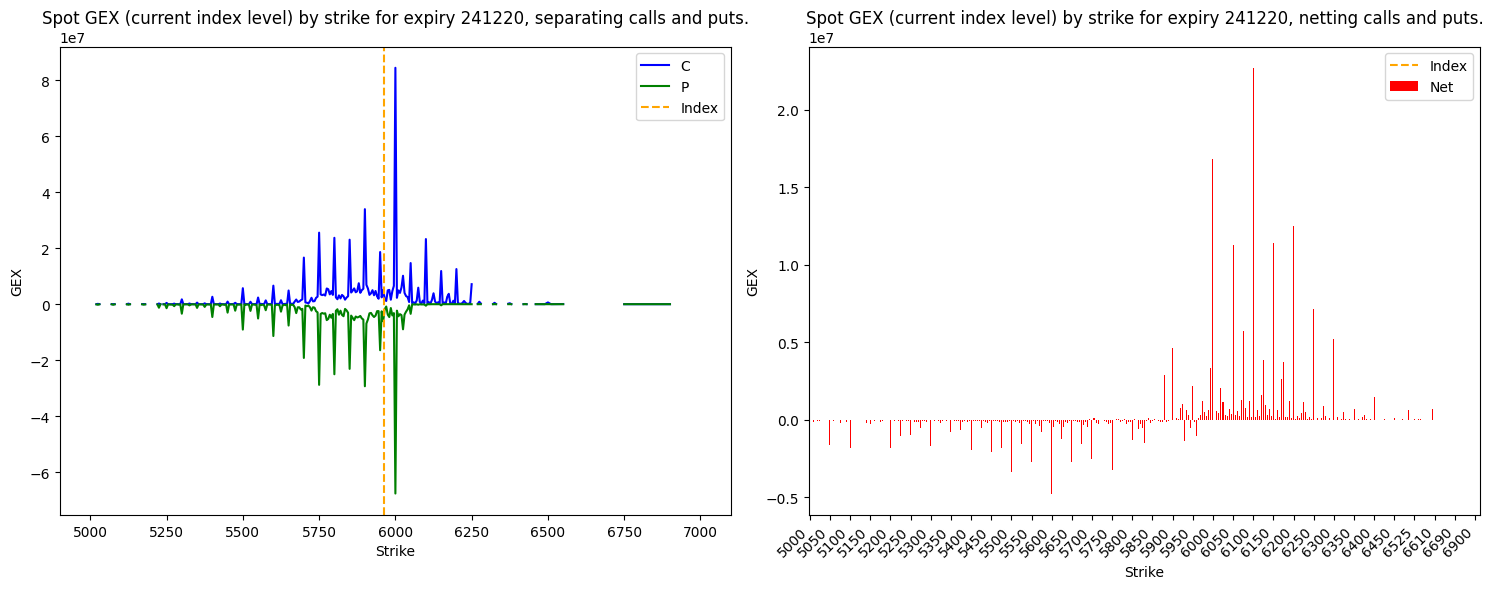

In [6]:
# Set up plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot GEX by strike for today's expiry, separating calls and puts
gex_surface.loc[('C', expiry)].loc[min_strike:max_strike].plot(ax=ax1, color='blue', label='C')
gex_surface.loc[('P', expiry)].loc[min_strike:max_strike].plot(ax=ax1, color='green', label='P')
ax1.set_title(f'Spot GEX (current index level) by strike for expiry {expiry}, separating calls and puts.')
ax1.axvline(x=df['Index Price'][0], color='orange', linestyle='--', label='Index')
ax1.set_ylabel('GEX')
ax1.legend()

# Plot GEX by strike for today's expiry, netting calls and puts
gex_net_surface.loc[expiry].loc[min_strike:max_strike].plot(ax=ax2, color='red', label='Net', kind='bar')
ax2.set_title(f'Spot GEX (current index level) by strike for expiry {expiry}, netting calls and puts.')
ax2.axvline(x=df['Index Price'][0], color='orange', linestyle='--', label='Index')
ax2.set_ylabel('GEX')
xticks = ax2.get_xticks()
ax2.set_xticks(xticks[::10])
ax2.set_xticklabels(gex_net_surface.loc[expiry].loc[min_strike:max_strike].index[::10], rotation=45, ha='right')
ax2.legend()

# Display
plt.tight_layout()
plt.show()

What does this chart tell us? Let's look at the net chart on the right. Note there is some TURNING POINT where we go from net positive gamma to net negative gamma. We then look at where the index is trading, either in the positive gamma zone or the negative gamma zone.

* If the index is trading in the positive gamma zone, we are in a **volatility stabilizing** market and dealers are supplying liquidity to the market since their hedging flows are always in the opposite direction to the way the market is moving. Why is this? Because dealers are long gamma. So:
    * If the underlying market moves up, delta moves up, so dealers must sell the underlying, which pushes the price of the underlying back down and keeps it stable.
    * If the underlying market moves down, delta moves down, so dealers must buy the underlying, which pushes the price of the underlying back up and keeps it stable.

* If the index is trading in the negative gamma zone, we are in a **volatility destabilizing** market and dealers are taking liquidity from the market since their hedging flows are always in the same direction to the way the market is moving. Why is this? Because dealers are short gamma. So:
    * If the underlying market moves up, delta moves down, so dealers must buy the underlying, which pushes the price of the underlying up even further, which is destabilising.
    * If the underlying market moves down, delta moves up, so dealers must sell the underlying, which pushes the price of the underlying down even further, which is destabilising.


In [7]:
# TODO: Look at all expiries and reak down the bars by expiry in a stacked. Also do all bar charts. Also colour code green and red the gamma turning point and add a verticual line for where the index is trading and see if it's in the green or red. 